# Group 22

# 1- Summary

Our project scraps player and team statistics from the NBA official site. In this python notebook, we process this data to be represented as:
   <br>1. Bar Chart of the Top 10 NBA players according to points.
   <br>2. Histogram of the age distribution of NBA players.
   <br>3. Heatmap of the correlation between Points and Field Goals Made.
   <br>4. Boxplot of the distribution of Team wins in NBA
   <br>5. Scatter plot of Field Goals Made against Points.

Upon obtaining linear distribution on the scatter plot, we decided to find the line of best fit.

We went ahead to train a Simple Linear Model from the data of Field Goals Made against Points. We split the data into train and test set with a test size of 0.2. We display our predicted values against the actual values for comparison.

Furthermore, we created an interactive program with the following features:
    <br>i. Display player statistics: This makes use of the code we used to scrape our player statistics data.
    <br>ii. Display team statistics: This makes use of the code we used to scrape our team statistics data.
    <br>iii. Display Bar Chart of Top 10 NBA players
    <br>iv. Display Histogram of the Distribution of NBA players' age
    <br>v. Display Heatmap of the Correlation of Points and Field Goals Made
    <br>vi. Display Boxplot of the distribution of Team Wins
    <br>vii. Display Scatter plot of players' Field Goals Made against players' Points
    <br>viii. Predict Player Points
    <br>ix. Predict player points based on field goals made value provided: This makes use of our trained model to predict the points.

# 2- Web Scraping

Our program requires data on the statistics of team players (https://www.nba.com/stats/players/traditional/?sort=PTS&dir=-1)  and teams (https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1). The scraped data is stored in a csv file ie "player_stats.csv" for team player statistics and "team_stats.csv" for team statistics.

# Importing libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import csv
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set()

# Web Scraping For Player Stats

In [2]:
def scrape_player_stats():
    pd.set_option('display.max_columns', None)
    browser = webdriver.Chrome('./chromedriver.exe')
    url = "https://www.nba.com/stats/players/traditional/?sort=PTS&dir=-1"
    browser.get(url)
    time.sleep(2)
    accept_button = browser.find_element(By.ID,"onetrust-accept-btn-handler")
    time.sleep(1)
    accept_button.click()
    time.sleep(2)
    browser.find_element(By.CSS_SELECTOR,".stats-table-pagination__select:nth-child(1) option").click()
    time.sleep(2)
    soup = BeautifulSoup(browser.page_source, "lxml")
    headers = soup.select(".nba-stat-table__overflow table thead tr:nth-child(1)")
    rows_soup = soup.select(".nba-stat-table__overflow table tbody tr")
    columns = ['ID']
    columns.extend([col.get_text(strip=True) for col in headers[0].findChildren("th" , recursive=False) if col.get_text(strip=True) != ""])
    # for col in headers[0].findChildren("th" , recursive=False):
    #     if col.get_text(strip=True) != "":
    #          columns.extend([col.get_text(strip=True)])
    rows = []
    for i in range(len(rows_soup)):
        rows.append([x.get_text(strip=True) for x in rows_soup[i].findChildren("td" , recursive=False) if x.get_text(strip=True) != ""])

    with open('player_stats.csv', 'w', encoding="utf-8", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(columns)
        for row in rows:
            writer.writerow(row)
            
scrape_player_stats()

<ipython-input-2-dbc361919a81>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe')


# Web Scraping for Team Stats

In [3]:
def scrape_team_stats():
    pd.set_option('display.max_columns', None)
    browser = webdriver.Chrome('./chromedriver.exe')
    url = "https://www.nba.com/stats/teams/traditional/?sort=W_PCT&dir=-1"
    browser.get(url)
    time.sleep(2)
    soup = BeautifulSoup(browser.page_source, "html.parser")
    headers = soup.select(".nba-stat-table__overflow table thead tr:nth-child(1)")
    rows_soup = soup.select(".nba-stat-table__overflow table tbody tr")
    columns = ['ID']
    columns.extend([col.get_text(strip=True) for col in headers[0].findChildren("th" , recursive=False) if col.get_text(strip=True) != ""])
    rows = []
    for i in range(len(rows_soup)):
        rows.append([x.get_text(strip=True) for x in rows_soup[i].findChildren("td" , recursive=False) if x.get_text(strip=True) != ""])

    with open('team_stats.csv', 'w', encoding="utf-8", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(columns)
        for row in rows:
            writer.writerow(row)
            
scrape_team_stats()

<ipython-input-3-0b9ea4a126e0>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe')


## Reading Player Stats

In [4]:
data1 = pd.read_csv('player_stats.csv')

# 3- Data Science

# Data Preprocessing

## Dealing with missing values

Dropping all columns with missing values.

In [5]:
data1 = data1.dropna(axis=1)

In [6]:
data1

,ID,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,1,Kevin Durant,BKN,33,27,20,7,37.0,29.7,10.8,20.6,52.3,1.9,4.9,38.2,6.3,7.1,88.6,0.5,7.4,7.9,5.9,3.2,0.6,0.9,1.8,49.2,10,2,4.9
1,2,Trae Young,ATL,23,29,14,15,34.2,27.3,9.5,20.6,46.0,2.7,7.1,37.7,5.6,6.3,89.1,0.8,3.2,4.0,9.3,4.1,1.0,0.1,1.7,45.4,15,0,2.9
2,3,Giannis Antetokounmpo,MIL,27,26,17,9,32.6,27.0,9.5,18.0,52.9,1.1,3.8,28.0,6.9,10.1,68.1,2.0,9.5,11.6,5.8,3.3,1.1,1.6,3.0,54.4,16,1,7.6
3,4,Stephen Curry,GSW,33,28,23,5,34.3,27.0,8.7,20.3,43.0,5.4,13.5,39.8,4.2,4.5,92.9,0.7,4.8,5.5,6.1,3.4,1.6,0.5,2.0,45.5,6,1,11.3
4,5,DeMar DeRozan,CHI,32,25,17,8,35.2,26.8,9.5,19.2,49.6,0.8,2.4,33.3,7.0,7.8,89.3,0.6,4.6,5.2,4.2,2.1,0.9,0.4,2.3,41.1,1,0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,478,Malik Fitts,UTA,24,4,4,0,2.6,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.9,0,0,-0.8
491,478,Neemias Queta,SAC,22,1,0,1,7.7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,1.0,0.0,0.0,1.0,1.0,10.5,0,0,-9.0
492,478,Sam Dekker,TOR,27,1,1,0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-5.0
493,478,Trevelin Queen,HOU,24,1,1,0,2.8,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-9.0


## Determining variables of interest

Dropping 'ID' column because it is not useful in our data.

In [7]:
data1 = data1.drop('ID', axis=1)

# Data Visualisation

Sorting data in descending order according to player points(PTS).

In [8]:
data = data1.sort_values(by = ['PTS'], ascending = False) 

In [9]:
data

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,Kevin Durant,BKN,33,27,20,7,37.0,29.7,10.8,20.6,52.3,1.9,4.9,38.2,6.3,7.1,88.6,0.5,7.4,7.9,5.9,3.2,0.6,0.9,1.8,49.2,10,2,4.9
1,Trae Young,ATL,23,29,14,15,34.2,27.3,9.5,20.6,46.0,2.7,7.1,37.7,5.6,6.3,89.1,0.8,3.2,4.0,9.3,4.1,1.0,0.1,1.7,45.4,15,0,2.9
2,Giannis Antetokounmpo,MIL,27,26,17,9,32.6,27.0,9.5,18.0,52.9,1.1,3.8,28.0,6.9,10.1,68.1,2.0,9.5,11.6,5.8,3.3,1.1,1.6,3.0,54.4,16,1,7.6
3,Stephen Curry,GSW,33,28,23,5,34.3,27.0,8.7,20.3,43.0,5.4,13.5,39.8,4.2,4.5,92.9,0.7,4.8,5.5,6.1,3.4,1.6,0.5,2.0,45.5,6,1,11.3
4,DeMar DeRozan,CHI,32,25,17,8,35.2,26.8,9.5,19.2,49.6,0.8,2.4,33.3,7.0,7.8,89.3,0.6,4.6,5.2,4.2,2.1,0.9,0.4,2.3,41.1,1,0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Daishen Nix,HOU,19,1,1,0,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.5,0,0,-4.0
479,Brodric Thomas,BOS,24,4,2,2,2.0,0.0,0.0,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.3,0.0,0.3,0.0,0.5,0.0,0.0,0.0,-0.2,0,0,-4.3
478,Arnoldas Kulboka,CHA,23,1,1,0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-8.0
477,Aaron Henry,PHI,22,1,1,0,2.1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-6.0


Taking the top 10 players according to their points.

In [10]:
data2 = data.head(10)

## Bar Chart

Bar Chart showing the Top 10 NBA Players

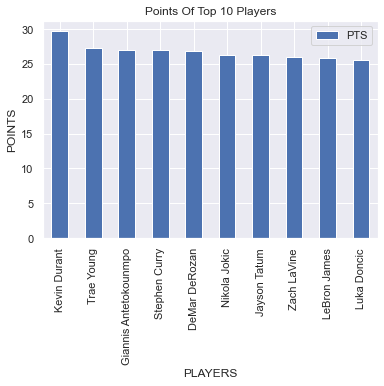

In [11]:
data2.plot.bar(x='PLAYER', y='PTS', title='Points Of Top 10 Players')
plt.xlabel('PLAYERS')
plt.ylabel('POINTS')
plt.show(block=True)

From the chart above, Kevin Durant is the highest ranking NBA players based on points.

# Histogram

Histogram showing the distribution of NBA players' ages

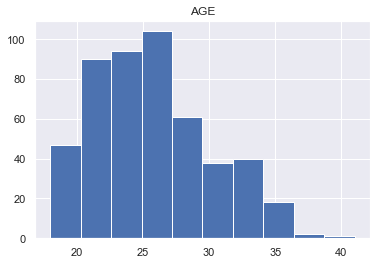

In [12]:
data.hist('AGE')
plt.show()

From the chart above, the highest distribution of ages of NBA players ranges from 20 to 27.

## Correlation

Finding the correlation between player points(PTS) and field goals made(FGM)

In [13]:
cor = data.iloc[:, [7,8]].corr()

# Heatmap

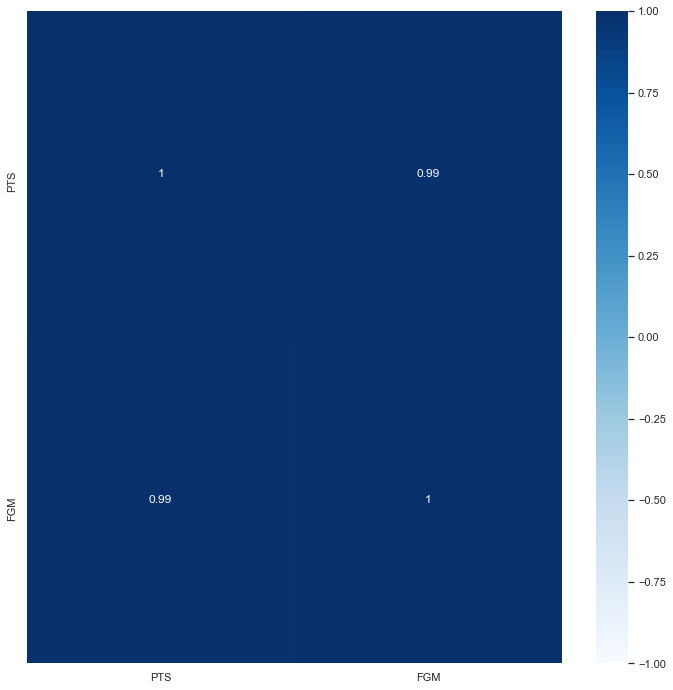

In [14]:
plt.figure(figsize=(12,12))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, center=0, vmax=1, vmin=-1)
plt.show()

From the heatmap above, players' points(PTS) and field goals made(FGM) are highly correlated.

## Reading Team Stats

In [15]:
team_data = pd.read_csv('team_stats.csv')

In [16]:
team_data.describe()

,ID,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,GP RANK,W RANK,L RANK,WIN% RANK,MIN RANK,PTS RANK,FGM RANK,FGA RANK,FG% RANK,3PM RANK,3PA RANK,3P% RANK,FTM RANK,FTA RANK,FT% RANK,OREB RANK,DREB RANK,REB RANK,AST RANK,TOV RANK,STL RANK,BLK RANK,BLKA RANK,PF RANK,PFD RANK,+/- RANK
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,15.033333,30.066667,15.033333,15.033333,0.500167,48.310000,107.873333,39.883333,88.13000,45.256667,12.360000,35.483333,34.836667,15.756667,20.393333,77.296667,10.213333,34.603333,44.826667,23.793333,14.253333,7.766667,4.876667,4.896667,19.186667,19.190000,0.013333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,8.719709,1.080655,4.529469,4.567376,0.151898,0.291666,3.819544,1.731072,2.23532,1.710149,1.343336,3.326703,1.876439,1.153610,1.439333,2.790932,1.201072,1.400612,1.440291,1.896809,1.259100,0.891467,0.666790,0.719906,1.210794,0.989723,4.964476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,28.000000,5.000000,5.000000,0.172000,48.000000,99.100000,36.100000,84.50000,41.300000,9.800000,29.500000,30.900000,12.800000,17.300000,70.200000,8.100000,31.400000,41.800000,20.300000,12.200000,6.500000,3.100000,3.600000,16.600000,17.400000,-9.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.250000,29.000000,13.000000,13.000000,0.419000,48.200000,105.925000,38.925000,86.42500,44.325000,11.450000,33.000000,33.900000,15.075000,19.325000,75.325000,9.450000,33.900000,44.000000,22.550000,13.600000,7.200000,4.400000,4.525000,18.800000,18.425000,-2.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,14.000000,30.000000,15.000000,15.000000,0.500000,48.200000,108.250000,40.000000,87.70000,45.550000,12.250000,35.700000,35.050000,15.800000,20.500000,77.450000,10.100000,34.500000,45.000000,23.300000,14.150000,7.600000,4.850000,4.750000,19.250000,19.250000,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,22.000000,31.000000,18.000000,18.000000,0.590750,48.450000,110.375000,41.100000,89.07500,46.400000,12.975000,37.450000,36.200000,16.675000,21.075000,78.875000,10.650000,35.375000,45.775000,25.275000,15.150000,8.150000,5.300000,5.400000,19.800000,19.775000,2.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,30.000000,32.000000,24.000000,25.000000,0.828000,49.300000,115.600000,43.200000,92.60000,48.100000,15.700000,42.200000,38.000000,17.400000,24.200000,81.600000,13.000000,37.000000,47.100000,28.000000,17.600000,10.400000,6.000000,6.300000,22.600000,22.500000,10.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the description above, we have missing values in our data.

## Dealing with missing values

In [17]:
team_data=team_data.dropna(axis=1)

## Determining variables of interest

In [18]:
team_data=team_data.drop('ID', axis=1)

In [19]:
team_data

,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
0,Phoenix Suns,29,24,5,0.828,48.2,111.9,42.5,88.8,47.8,11.4,31.0,36.8,15.6,19.7,78.8,9.3,36.5,45.8,26.3,14.0,8.6,4.1,4.0,19.4,19.1,7.3
1,Golden State Warriors,30,24,6,0.800,48.2,111.4,40.5,86.2,46.9,14.8,40.9,36.2,15.6,20.7,75.6,9.9,37.0,46.9,28.0,16.1,9.2,4.9,3.8,20.3,18.4,10.3
2,Brooklyn Nets,30,21,9,0.700,48.2,109.7,40.5,87.3,46.4,11.6,32.7,35.3,17.1,21.0,81.6,9.1,36.4,45.5,25.3,14.2,6.8,5.3,4.9,19.4,19.8,3.4
3,Utah Jazz,29,20,9,0.690,48.0,115.6,41.6,86.4,48.1,15.7,42.2,37.1,16.7,21.6,77.4,10.1,36.6,46.7,22.7,14.6,7.2,5.3,4.0,18.9,19.4,10.4
4,Chicago Bulls,28,18,10,0.643,48.0,108.5,40.4,87.2,46.4,11.0,29.9,36.7,16.7,20.5,81.4,9.3,33.9,43.2,23.1,13.4,7.9,4.6,5.8,18.4,18.3,2.6
5,Cleveland Cavaliers,31,19,12,0.613,48.0,107.0,39.4,85.1,46.3,12.5,34.7,36.0,15.8,20.0,79.2,9.8,35.2,45.0,25.3,15.7,7.6,4.4,4.6,17.0,18.4,5.9
6,Memphis Grizzlies,31,19,12,0.613,48.3,111.1,41.7,92.1,45.3,12.0,34.5,34.8,15.8,21.0,75.1,12.6,34.5,47.1,25.3,13.6,10.4,5.9,6.3,19.2,18.6,2.4
7,Milwaukee Bucks,32,19,13,0.594,48.3,110.0,40.3,89.1,45.2,14.2,39.5,35.9,15.3,20.4,75.2,10.7,36.4,47.1,22.5,14.4,7.8,4.4,4.7,17.3,18.6,2.8
8,Miami Heat,31,18,13,0.581,48.3,106.6,38.9,84.5,46.0,13.0,35.7,36.5,15.8,20.1,78.8,10.2,33.8,44.0,25.2,15.0,7.1,3.1,4.6,20.3,19.8,2.9
9,LA Clippers,30,16,14,0.533,48.2,106.0,39.3,87.2,45.1,12.9,35.7,36.2,14.5,18.5,78.3,8.9,35.0,44.0,23.1,14.9,8.0,4.4,4.1,18.2,19.2,1.1


# Boxplot

Boxplot showing the distribution of team wins(W). 

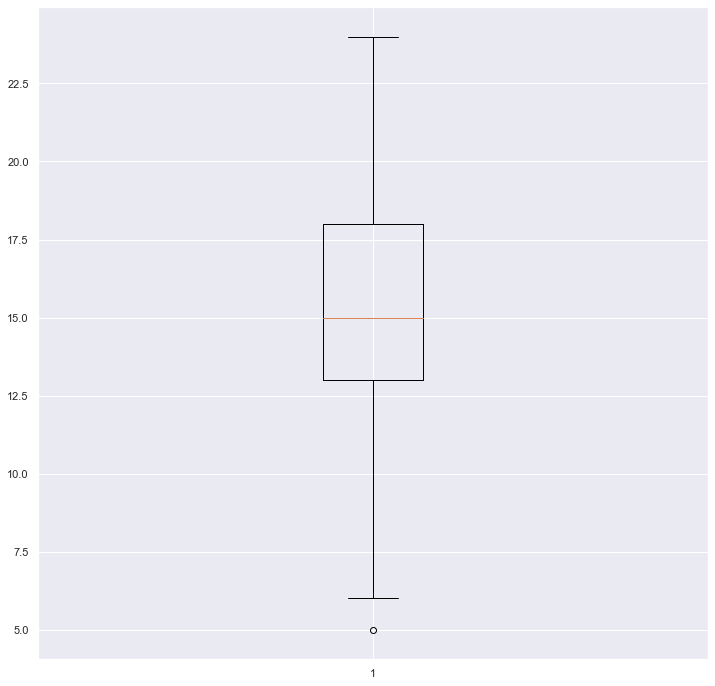

In [20]:
fig = plt.figure(figsize=(12,12))
plt.boxplot(team_data['W'])
plt.show()

From the boxplot above, we can discover that the team wins are positively skewed.

# Linear Regression

## Declaring independent and dependent variables

In [21]:
y = data['PTS']
x1 = data['FGM']

## Using the Ordinary Least Square (OLS) Model

### Determining coefficients and constants

In [22]:
x = sm.add_constant(x1)
results = sm.OLS(y,x)
results = results.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PTS   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 2.903e+04
Date:                Mon, 20 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:59:23   Log-Likelihood:                -610.35
No. Observations:                 495   AIC:                             1225.
Df Residuals:                     493   BIC:                             1233.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0232      0.062     -0.375      0.708      -0.144       0.098
FGM            2.7119      0.016    170.394      0.000       2.681       2.743
==============================================================================
Omnibus:                       85.357   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              475.241
Skew:                           0.604   Prob(JB):                    6.35e-104
Kurtosis:                       7.646   Cond. No.                         6.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### OLS Assumptions

1. Linearity
2. No endogenity
3. Normality and homoscedasticity: 
    i. Normality
    ii. Zero mean
    iii. Homoscedasticity
4. No autocorrelation
5. No multicolinearity

### Linearity

Checking for linearity, a scatter plot is employed
Dependent variable(s) is plotted against the independent variable.
So if dependent variable is not linear, its relationship with this independent variable will also not be linear.

#### Scatter plot

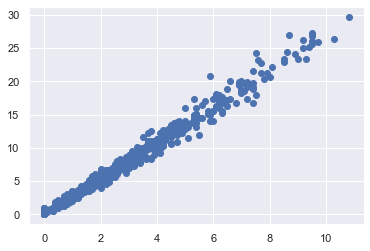

In [23]:
plt.scatter(x1, y)
plt.show()

From the scatter plot above, there is a linear relationship between the dependent variable (FGM) and the independent variable (PTS)

### Normality and homoscedasticity

Normality is assumed for a big sample.

In [24]:
data.shape

(495, 29)

Since our data has 483 rows x 29 columns, it is classified as a big sample. Hence, normality is implied.

Zero Mean is accomplished with the inclusion of the intercept of the regression.
In our OLS Model, our intercept is included.

Error turn should have equal variance with one another. This problem is checked when we draw the regression line. In an exponential scatter plot, log transformation can be used to deal with it.

### No autocorrelation

Since our data is not a time series or panel data, autocorrelation is checked. Autocorrelation arises from time series data or panel data.

### No multicolinearity

Multicolinearity arises when there is a correlation between two independent variables. In our case, we have only one independent variable.

## Simple Linear Regression

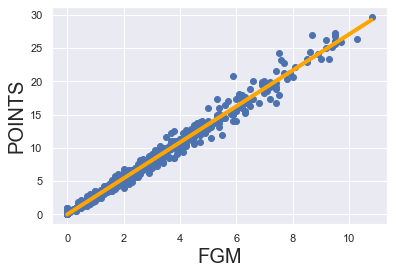

In [25]:
plt.scatter(x1, y)
yhat = 2.7065*x1 -0.0091
fig = plt.plot(x1,yhat, lw=4, c='orange', label='regression line')
plt.xlabel('FGM', fontsize=20)
plt.ylabel('POINTS', fontsize=20)
plt.show()

The above is a scatter plot showing the best fit line for our simple linear regression.

# 4- Training and Testing Linear Regression Model

## Declaration of Variables

In [26]:
X = data.iloc[:,7].values.reshape(-1,1)
Y = data.iloc[:, 8].values.reshape(-1,1)

## Splitting of data into training and test data

In [27]:
X_train, X_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state=10)

## Training Model

In [28]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## Checking regression score

In [29]:
regressor.score(X_test, y_test)

0.979697630604002

From the above score, we have 98.67% accuracy.

## Testing of Model

In [30]:
y_pred = regressor.predict(X_test)
evaluate = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
evaluate.head(10)

,Actual,Predicted
0,2.5,2.228535
1,1.5,1.501714
2,4.0,3.900224
3,2.2,1.974148
4,4.7,4.009247
5,2.2,2.046830
6,3.4,3.282426
7,3.0,2.882674
8,1.0,1.138303
9,2.0,1.865124


# Interactive program

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 1


<ipython-input-2-dbc361919a81>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe')


,ID,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,1,Kevin Durant,BKN,33,27,20,7,37.0,29.7,10.8,20.6,52.3,1.9,4.9,38.2,6.3,7.1,88.6,0.5,7.4,7.9,5.9,3.2,0.6,0.9,1.8,49.2,10,2,4.9
1,2,Trae Young,ATL,23,29,14,15,34.2,27.3,9.5,20.6,46.0,2.7,7.1,37.7,5.6,6.3,89.1,0.8,3.2,4.0,9.3,4.1,1.0,0.1,1.7,45.4,15,0,2.9
2,3,Giannis Antetokounmpo,MIL,27,26,17,9,32.6,27.0,9.5,18.0,52.9,1.1,3.8,28.0,6.9,10.1,68.1,2.0,9.5,11.6,5.8,3.3,1.1,1.6,3.0,54.4,16,1,7.6
3,4,Stephen Curry,GSW,33,28,23,5,34.3,27.0,8.7,20.3,43.0,5.4,13.5,39.8,4.2,4.5,92.9,0.7,4.8,5.5,6.1,3.4,1.6,0.5,2.0,45.5,6,1,11.3
4,5,DeMar DeRozan,CHI,32,25,17,8,35.2,26.8,9.5,19.2,49.6,0.8,2.4,33.3,7.0,7.8,89.3,0.6,4.6,5.2,4.2,2.1,0.9,0.4,2.3,41.1,1,0,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,478,Malik Fitts,UTA,24,4,4,0,2.6,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0,0.0,0.0,0.0,0.0,0.9,0,0,-0.8
491,478,Neemias Queta,SAC,22,1,0,1,7.7,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,5.0,1.0,0.0,0.0,1.0,1.0,10.5,0,0,-9.0
492,478,Sam Dekker,TOR,27,1,1,0,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-5.0
493,478,Trevelin Queen,HOU,24,1,1,0,2.8,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-9.0


1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 2


<ipython-input-3-0b9ea4a126e0>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome('./chromedriver.exe')


,ID,TEAM,GP,W,L,WIN%,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
0,1,Phoenix Suns,29,24,5,0.828,48.2,111.9,42.5,88.8,47.8,11.4,31.0,36.8,15.6,19.7,78.8,9.3,36.5,45.8,26.3,14.0,8.6,4.1,4.0,19.4,19.1,7.3
1,2,Golden State Warriors,30,24,6,0.800,48.2,111.4,40.5,86.2,46.9,14.8,40.9,36.2,15.6,20.7,75.6,9.9,37.0,46.9,28.0,16.1,9.2,4.9,3.8,20.3,18.4,10.3
2,3,Brooklyn Nets,30,21,9,0.700,48.2,109.7,40.5,87.3,46.4,11.6,32.7,35.3,17.1,21.0,81.6,9.1,36.4,45.5,25.3,14.2,6.8,5.3,4.9,19.4,19.8,3.4
3,4,Utah Jazz,29,20,9,0.690,48.0,115.6,41.6,86.4,48.1,15.7,42.2,37.1,16.7,21.6,77.4,10.1,36.6,46.7,22.7,14.6,7.2,5.3,4.0,18.9,19.4,10.4
4,5,Chicago Bulls,28,18,10,0.643,48.0,108.5,40.4,87.2,46.4,11.0,29.9,36.7,16.7,20.5,81.4,9.3,33.9,43.2,23.1,13.4,7.9,4.6,5.8,18.4,18.3,2.6
5,6,Cleveland Cavaliers,31,19,12,0.613,48.0,107.0,39.4,85.1,46.3,12.5,34.7,36.0,15.8,20.0,79.2,9.8,35.2,45.0,25.3,15.7,7.6,4.4,4.6,17.0,18.4,5.9
6,6,Memphis Grizzlies,31,19,12,0.613,48.3,111.1,41.7,92.1,45.3,12.0,34.5,34.8,15.8,21.0,75.1,12.6,34.5,47.1,25.3,13.6,10.4,5.9,6.3,19.2,18.6,2.4
7,8,Milwaukee Bucks,32,19,13,0.594,48.3,110.0,40.3,89.1,45.2,14.2,39.5,35.9,15.3,20.4,75.2,10.7,36.4,47.1,22.5,14.4,7.8,4.4,4.7,17.3,18.6,2.8
8,9,Miami Heat,31,18,13,0.581,48.3,106.6,38.9,84.5,46.0,13.0,35.7,36.5,15.8,20.1,78.8,10.2,33.8,44.0,25.2,15.0,7.1,3.1,4.6,20.3,19.8,2.9
9,10,LA Clippers,30,16,14,0.533,48.2,106.0,39.3,87.2,45.1,12.9,35.7,36.2,14.5,18.5,78.3,8.9,35.0,44.0,23.1,14.9,8.0,4.4,4.1,18.2,19.2,1.1


1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 3


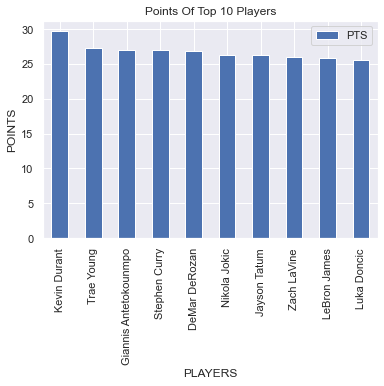

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 4


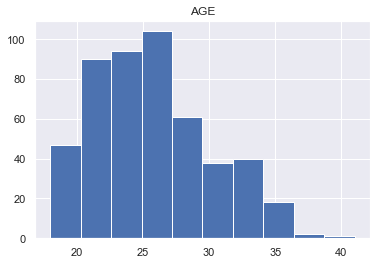

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 5


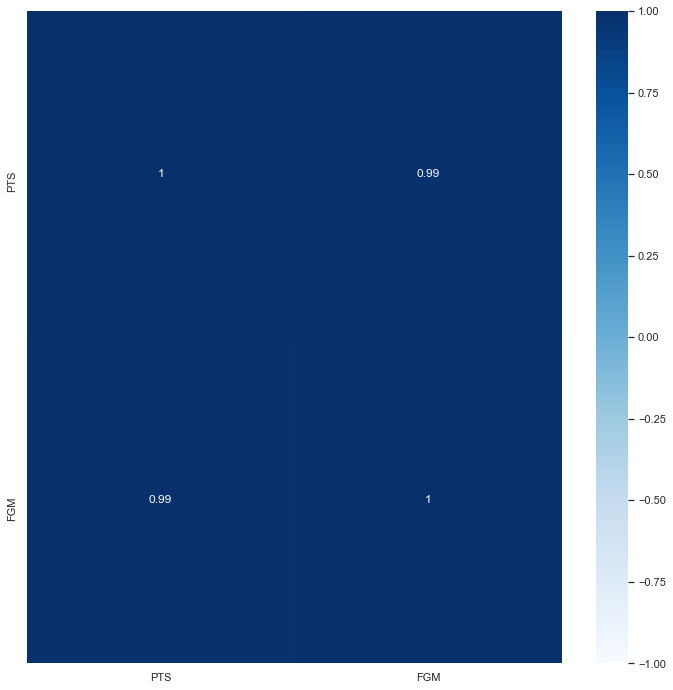

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 6


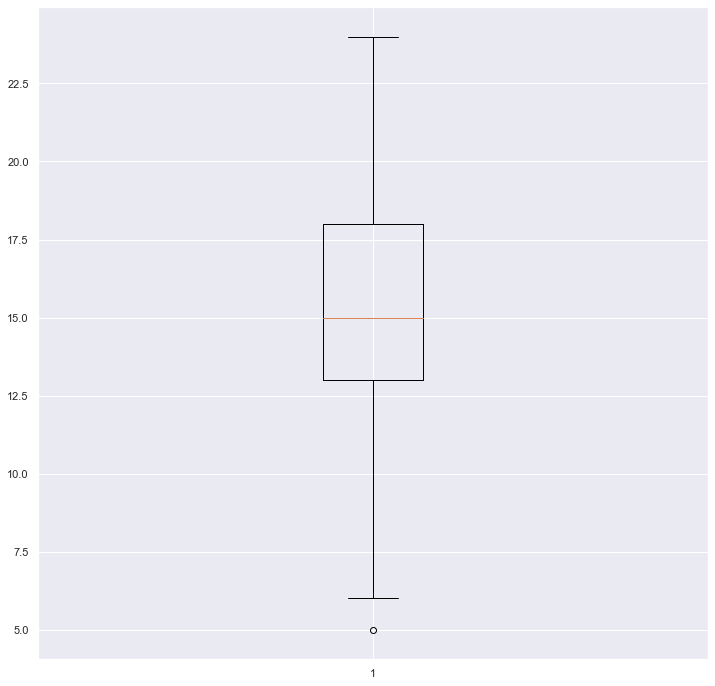

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 7


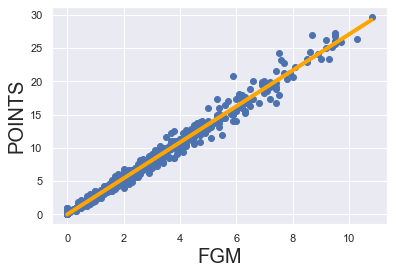

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 8
Enter Expected Field Goals Made by player:
Input: 5


1.8651244405102598

1. Display Player Stats
2. Display Team Stats
3. Display Bar Chart of Top 10 NBA players
4. Display Histogram of the Distribution of NBA players' age
5. Display Heatmap of the Correlation of Points and Field Goals Made
6. Display Boxplot of the distribution of Team Wins
7. Display Scatter plot of players' Field Goals Made against players' Points
8. Predict Player Points
10. Exit
Input: 10


In [31]:
from IPython.display import display
def main_program():
    choice = input('''1. Display Player Stats\n2. Display Team Stats\n3. Display Bar Chart of Top 10 NBA players\n4. Display Histogram of the Distribution of NBA players' age\n5. Display Heatmap of the Correlation of Points and Field Goals Made\n6. Display Boxplot of the distribution of Team Wins\n7. Display Scatter plot of players' Field Goals Made against players' Points\n8. Predict Player Points\n10. Exit\nInput: ''')

    if choice == "1":
        scrape_player_stats()
        result = pd.read_csv('player_stats.csv')
        result = result.dropna(axis=1)
        display(result)
        main_program()

    elif choice == "2":
        scrape_team_stats()
        result = pd.read_csv('team_stats.csv')
        result = result.dropna(axis=1)
        display(result)
        main_program()
        
    elif choice == "3":
        data2.plot.bar(x='PLAYER', y='PTS', title='Points Of Top 10 Players')
        plt.xlabel('PLAYERS')
        plt.ylabel('POINTS')
        plt.show(block=True)
        main_program()
        
    elif choice == "4":
        data.hist('AGE')
        plt.show()
        main_program()
        
    elif choice == "5":
        plt.figure(figsize=(12,12))
        sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, center=0, vmax=1, vmin=-1)
        plt.show()
        main_program()
        
    elif choice == "6":
        fig = plt.figure(figsize=(12,12))
        plt.boxplot(team_data['W'])
        plt.show()
        main_program()
        
    elif choice == "7":
        plt.scatter(x1, y)
        yhat = 2.7065*x1 -0.0091
        fig = plt.plot(x1,yhat, lw=4, c='orange', label='regression line')
        plt.xlabel('FGM', fontsize=20)
        plt.ylabel('POINTS', fontsize=20)
        plt.show()
        main_program()
        
    elif choice == "8":
        choice = input("Enter Expected Field Goals Made by player:\nInput: ")
        result = regressor.predict(np.array(float(choice)).reshape(-1, 1))
        display(result[0][0])
        main_program()
        
    elif choice == "10":
        pass
    
    else:
        main_program()
        
main_program()

# 5- Drawbacks 

1. Single independent variable: Our Simple Linear Model makes use of only one independent variable ie field goals made to predict points. This could make predictions by the model less accurate and biased. A Multiple Linear Regression Model would have been more appropriate.

2. 

# 6- Difficulties

1. Deprecated functions in Selenium: Functions such as "find_all_by_\*" have become deprecated and hence caused errors until an upgrade for the newer methods were implemented.